#### General notebook settings

In [1]:
%matplotlib inline

In [2]:
import sys
import os

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from scipy.stats import bartlett, levene, normaltest, mannwhitneyu
from scipy.stats.mstats import zscore
from scipy.stats import hypergeom
from statsmodels.sandbox.stats.multicomp import multipletests
import statsmodels.graphics.gofplots as sm
import random
import math

In [4]:
DIR = "InOutDirectory/"

## Task 1: KEGG and gene id mapping

Familiarize yourself with the KEGG Rest interface and how to access it with Biopyhton:

http://www.genome.jp/kegg/rest/keggapi.html

http://nbviewer.jupyter.org/github/widdowquinn/notebooks/blob/master/Biopython_KGML_intro.ipynb

### Subtask 1.1 Extract gene lists for all (mouse) KEGG pathways and store them in a suitable Python data structure

Import for the connection with KEGG.

In [24]:
from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from Bio.Graphics.ColorSpiral import ColorSpiral

from IPython.display import Image, HTML

In [6]:
# check the connection to KEGG
print(kegg_info("kegg").read())

kegg             Kyoto Encyclopedia of Genes and Genomes
kegg             Release 79.0+/09-28, Sep 16
                 Kanehisa Laboratories
                 pathway     462,412 entries
                 brite       165,896 entries
                 module      377,111 entries
                 disease       1,662 entries
                 drug         10,364 entries
                 environ         850 entries
                 orthology    20,133 entries
                 genome        4,750 entries
                 genes     20,175,595 entries
                 dgenes       99,485 entries
                 compound     17,752 entries
                 glycan       10,994 entries
                 reaction     10,252 entries
                 rpair               entries
                 rclass        3,059 entries
                 enzyme        6,791 entries



In [7]:
mouseGenesKEGG_pathways = kegg_list("pathway", "mmu").read()

In [8]:
mouseGenesKEGG_pathwayNames = [line.split("\t") for line in mouseGenesKEGG_pathways.split("\n")]

To get all genes for all pathways of mus musculus, the command kegg_get was used on every pathway ID. A suitable datastructure for storing all data (pathway ID, pathway description and appropriated genes) seems to be a python dictionary with the pathway ID as key. Just the gene names of every gene were stored.

In [9]:
# initialise dictionary
mousePathway = {} 

# loop over all pathways to get all genes for each pathway
for l in mouseGenesKEGG_pathwayNames[:-1]:
    
    # get all genes of a pathway
    temp_genes = kegg_get(l[0]).read()
    
    if "GENE" in temp_genes:
        # get all genes if this pathway contains genes
        temp_genes = temp_genes.replace("COMPOUND", "GENE").split("GENE")[1].split("\n")
        
        # create a list, starting with the pathway description followed by all genes in that pathway
        pathway_info = [l[1]] + [gene.split(";")[0].split(" ")[-1] for gene in temp_genes[:-1]]
    else:
        # else report just the pathway description as info
        pathway_info = [l[1]]
    
    # set the pathway id as key for the dictionary and fill it with the information list (description and genes)
    mousePathway[l[0]] = pathway_info

### Subtask 1.2: Save the KEGG gene sets as a gmt file after you made sure they have the proper gene ids with respect to your DE analysis

hints: 

http://biopython.org/wiki/Annotate_Entrez_Gene_IDs

http://www.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats

In [10]:
# initialise outfile
with open(DIR + "CompleteMousePathway.gmt", "w") as out:
    # emptystring for final save
    mouseGmt = ""
    for k in mousePathway:
        mouseGmt += k + "\t" + str(mousePathway[k]).replace("'", "")\
                                                   .replace("]", "")\
                                                   .replace("[", "")\
                                                   .replace(", ", "\t")\
                    + "\n"
                     
    out.write(mouseGmt)

## Task 2: Gene Set Enrichment

### Subtask 2.1: Read in the csv file you produced during the Differential Expression module, extract a gene list (as a python list of gene symbols) from your favorite multiple correction column (and store it in a variable)

In [12]:
fullMHTTable = pd.read_csv(DIR + "MHTsandFC.csv", index_col=0)

In [13]:
fullMHTTable.head()

,p_value,sidak_cor_pval,holm-sidak_cor_pval,holm_cor_pval,simes-hochberg_cor_pval,hommel_cor_pval,fdr_bh_cor_pval,fdr_by_cor_pval,fdr_tsbh_cor_pval,fdr_tsbky_cor_pval,log2FC
Igh,8.634098e-08,1.883393e-03,1.720503e-03,1.721984e-03,1.721725e-03,1.517184e-03,9.953373e-07,1.051919e-05,4.384973e-07,4.653523e-07,0.036313
Hcfc2,8.742707e-05,8.517664e-01,7.667686e-01,1.000000e+00,5.000000e-01,4.995801e-01,3.677223e-04,3.886259e-03,1.620006e-04,1.719221e-04,0.019963
Ccdc112,1.072951e-11,2.342685e-07,2.305239e-07,2.305236e-07,2.305129e-07,2.250516e-07,6.657274e-10,7.035715e-09,2.932872e-10,3.112491e-10,0.077491
EG635895,7.292464e-07,1.579628e-02,1.394280e-02,1.404091e-02,1.404091e-02,1.153522e-02,6.165232e-06,6.515702e-05,2.716102e-06,2.882445e-06,0.064943
Srp72,3.539137e-01,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e-01,5.000000e-01,3.899639e-01,1.000000e+00,1.717992e-01,1.823207e-01,0.000477


Two different gene lists are required for further analysis. One with all genes with are in both datasets, all genes which are occuring in the expressed genes and the genes from the KEGG, one with DE genes.

In [14]:
# all genes in KEGG, ignore the description they will automatically be removed in the next step
keggenes = []
for k in mousePathway:
    keggenes.extend(mousePathway[k])

# all genes in expression data
exprgenes = [str(gene) for gene in fullMHTTable.index.values]

# genes in both datasets
commongenes = list(set(keggenes) & set(exprgenes))

# differentially expressed genes
diffexprgenes = [str(gene) for gene in fullMHTTable[fullMHTTable.sidak_cor_pval < 0.05].index.values]
diffexprgenes = set(diffexprgenes) & set(commongenes)

In [15]:
crossDF = pd.DataFrame([[False, False]] * len(commongenes), index=commongenes, columns=["DE", "Pathway"])
crossDF.DE.loc[diffexprgenes] = True

In [16]:
crossDF.head()

,DE,Pathway
Plekhg5,False,False
Nampt,False,False
Yod1,False,False
Rgs14,False,False
Shank3,False,False


### Subtask 2.2: Perform gene set enrichment (Fisher's exact test or an hypergeometric test will do for our purposes) with the KEGG gene sets you extracted in Task 1 (you may want to store the results in a pandas dataframe and write them to csv)

hint:

https://genetrail2.bioinf.uni-sb.de/help?topic=set_level_statistics

In [17]:
signPathways = pd.DataFrame([1.0] * len(mousePathway), index=mousePathway, columns=["p_value"])

In [18]:
# test on one pathway
pathwaygenes = list(set(mousePathway["path:mmu00010"]) & set(commongenes))

curCrossDF = crossDF.copy()
curCrossDF.Pathway.loc[pathwaygenes] = True
ct = pd.crosstab((curCrossDF.DE == True).replace([False, True], ["not DE", "DE"]), 
                 (curCrossDF.Pathway == True).replace([False, True], ["not Pathway", "Pathway"]),
                 margins=True)
n = ct.All.DE
l = ct.Pathway.All
m = ct.All.All
k = ct.Pathway.DE

kprime = (n * l) / m

if kprime >= k:
    print hypergeom.cdf(k, m, l, n)
else:
    print hypergeom.sf(k-1, m, l, n)

0.175265232642


In [19]:
# for all pathways
for key in mousePathway:
    # get all possible pathway genes
    pathwaygenes = list(set(mousePathway[key]) & set(commongenes))
    
    if len(pathwaygenes) == 0:
        continue

    # prepare a cross table for the current pathway 
    curCrossDF = crossDF.copy()
    curCrossDF.Pathway.loc[pathwaygenes] = True
    ct = pd.crosstab((curCrossDF.DE == True).replace([False, True], ["not DE", "DE"]), 
                     (curCrossDF.Pathway == True).replace([False, True], ["not Pathway", "Pathway"]),
                     margins=True)
    # get the variables according to GeneTrail
    n = ct.All.DE
    l = ct.Pathway.All
    m = ct.All.All
    k = ct.Pathway.DE
    kprime = (n * l) / m

    # select the hypergeometric test and store it
    if kprime >= k:
        signPathways.p_value.loc[key] = hypergeom.cdf(k, m, l, n)
    else:
        signPathways.p_value.loc[key] = hypergeom.sf(k-1, m, l, n)

In [20]:
signPathways.to_csv(DIR + "SignificantPathways.csv", na_rep="x")

### Subtask 2.3: Extract a list of significantly (at 0.05 significance) enriched KEGG pathways

In [21]:
res = multipletests(signPathways.p_value.values, alpha=0.05, method="sidak")
res = pd.DataFrame([res[1], res[0]], index =["sidak_cor_pval", "sidak_rej"], columns=signPathways.index).T
signPathways = signPathways.join(res)

In [22]:
signPathways[signPathways.p_value < 0.05]

,p_value,sidak_cor_pval,sidak_rej
path:mmu00052,3.669043e-02,0.999987,False
path:mmu00190,1.199564e-02,0.973868,False
path:mmu00512,3.124239e-02,0.999931,False
path:mmu05202,2.181985e-02,0.998722,False
path:mmu05016,9.387543e-03,0.942065,False
path:mmu05010,1.864683e-02,0.996602,False
path:mmu05012,2.834375e-03,0.57565,False
path:mmu05332,1.826097e-03,0.424195,False
path:mmu04390,1.112213e-02,0.965874,False
path:mmu04962,1.675708e-02,0.993925,False


In [23]:
signPathways[signPathways.sidak_rej == True]

,p_value,sidak_cor_pval,sidak_rej
path:mmu04740,1.342473e-13,4.05362e-11,True


After multiple hypothesis testing with the Sidak method, just one pathway (mmu04740) remains as significant aftergene set enrichment. Without the correction it would have been 24 pathways.

## Task 3: KEGG map visualization

#### hint:

http://nbviewer.jupyter.org/github/widdowquinn/notebooks/blob/master/Biopython_KGML_intro.ipynb

#### remark:

In real life you may want to use the R-based tool pathview: https://bioconductor.org/packages/release/bioc/html/pathview.html (if you insist you can also try to use r2py for using pathview from Python during the practical)

For Python (in addition to the Biopyhton module) https://github.com/idekerlab/py2cytoscape in combination with https://github.com/idekerlab/KEGGscape may be another alternative (in the future)

Generally speaking, it is always a good idea to pay attention also to other pathway databases like Reactome or WikiPathways ...

### Subtask 3.1: Pick some significantly enriched KEGG pathways of your choice from 2.3 and visualize them

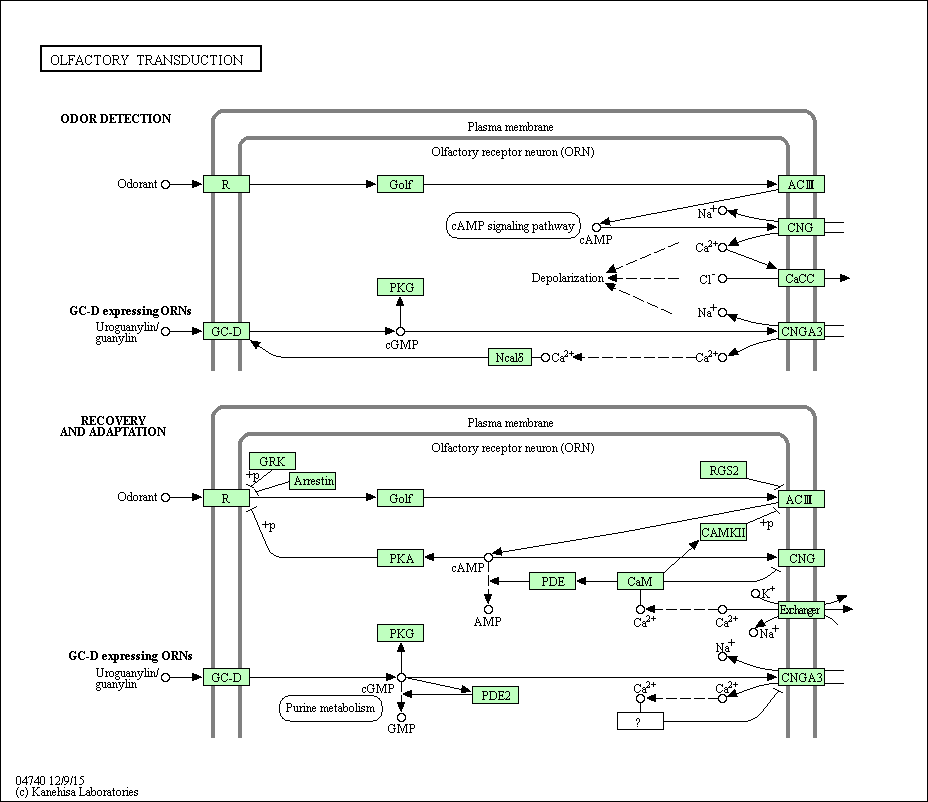

In [31]:
significantPathway = str(signPathways[signPathways.sidak_rej == True].index.values).replace("['", "").replace("']", "")
Image(kegg_get(significantPathway, "image").read())

### Subtask 3.2: Define a a suitable binary color scheme respresenting the fact whether a gene is significantly expressed or not

hint: 

http://www.rapidtables.com/web/color/RGB_Color.htm

Due to the fact that it is just relevant to spot whether a gene is differentially expressed or not, differentially exressed genes could get coloured magenta (#FF00FF), whereas not differentially expressed genes stay in the pale green which seems to be the standard colour in KEGG pathways. Therefore magenta was chosen and not red, because even people with dyschromatopsia are able to differentiate this colour from green.

### Subtask 3.3: Visualize the pathway(s) from 3.1 in such a way that the included genes have the corresponding color from 3.2 ( you may need to define a suitable mapping from single genes to what is actually shown in the pathway map...)

In [41]:
def PDF(filename):
    return HTML('<iframe src=%s width=975 height=650></iframe>' % filename)

In [229]:
def colouredDEPathway(pw, degenes, de="#FF00FF", notDE="#CCFFCC", dir_=""):
    '''
    function to draw a pathway with coloured pathway steps
    
    pw
        String name of the pathway which shall be drawn
    degenes
        list of Strings with names of differentially expressed genes
    de/notDE
        String with hex to define the colour for differentially expressed or not, by default #FF00FF and #CCFFCC
    dir_
        String with the storing directory of the pdf file, by default ""
        
    function returns a pdf image inside the notebook
    '''
    pathway = KGML_parser.read(kegg_get(pw, "kgml"))

    # Change the colours of gene elements if one gene in the step is differentially expressed
    for element in pathway.genes:
        
        # set not differentially expressed colour
        for graphic in element.graphics:
            graphic.bgcolor = notDE
        # get all ncbi gene ids of the element
        for n in element.name.split():
            # get the kegg entry of the gene id and extract the symbol names
            geneInfo = kegg_get(n).read()
            if "NAME" in geneInfo:
                # check the genes in the pathway with the differentially expressed genes
                dEGenes = len(set(geneInfo.split("NAME")[1].split("\n")[0].strip().split(", ")) & set(degenes))

                # if one gene of the differential expressed genes is in the pathway step colour the step box and break
                # the loop over the genes in the pathway step and continue with the next element
                if dEGenes > 0:
                    for graphic in element.graphics:
                        graphic.bgcolor = de
                    break

    # drawing of the pathway like described on http://www.rapidtables.com/web/color/RGB_Color.htm
    canvas = KGMLCanvas(pathway, import_imagemap=True)
    canvas.draw(dir_ + "ColouredDEPathway.pdf")
    return PDF(dir_ + "ColouredDEPathway.pdf")

In [230]:
colouredDEPathway(significantPathway, diffexprgenes, dir_=DIR)

### Subtask 3.4: Define a suitable continuous color range representing the log2 fold changes of the all the genes in your data

hint:

http://bsou.io/posts/color-gradients-with-python

In [136]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
                        "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
    colors in RGB and hex form for use in a graphing function
    defined later on '''
    return {"hex":[RGB_to_hex(RGB) for RGB in gradient],
            "r":[RGB[0] for RGB in gradient],
            "g":[RGB[1] for RGB in gradient],
            "b":[RGB[2] for RGB in gradient]}

def linear_gradient(start_hex, finish_hex="#FFFFFF", n=10):
    ''' returns a gradient list of (n) colors between
    two hex colors. start_hex and finish_hex
    should be the full six-digit color string,
    inlcuding the number sign ("#FFFFFF") '''
    # Starting and ending colors in RGB form
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(finish_hex)
    # Initilize a list of the output colors with the starting color
    RGB_list = [s]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            int(s[j] + (float(t)/(n-1))*(f[j]-s[j]))
            for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)

    return color_dict(RGB_list)

def polylinear_gradient(colors, n):
    ''' returns a list of colors forming linear gradients between
      all sequential pairs of colors. "n" specifies the total
      number of desired output colors '''
    # The number of colors per individual linear gradient
    n_out = int(float(n) / (len(colors) - 1))
    # returns dictionary defined by color_dict()
    gradient_dict = linear_gradient(colors[0], colors[1], n_out)

    if len(colors) > 1:
        for col in range(1, len(colors) - 1):
            next = linear_gradient(colors[col], colors[col+1], n_out)
            for k in ("hex", "r", "g", "b"):
                # Exclude first point to avoid duplicates
                gradient_dict[k] += next[k][1:]

    return gradient_dict

In [185]:
def colourDict(l2fc, stepsize=0.1):
    '''
    function that generates a diverging colour dictionary onto a log2 fold change series
    
    l2fc
        list or np.array with all log2 fold changes
    steps
        float value of stepsize of the range, by default 11
        
    function returns a dictionary
    '''
    
    # get the range of the values, round and "ceil" it to one digit
    r = round(np.ceil(max(abs(np.array(l2fc))) * 10) / 10, 1)
    
    # create a range of -r to r with stepsize
    bins = np.arange(-r, r+stepsize, stepsize)
    
    # create a colour gradient with the functions from http://bsou.io/posts/color-gradients-with-python
    # from yellow over white to blue
    colours = polylinear_gradient(["#FFF200", "FFFFFF", "0066FF"], len(bins) + 1)["hex"]
    
    # create the dictionary
    cD = {}
    for i, b in enumerate(bins):
        cD[round(b, 1)] = colours[i]
    
    return cD

In [186]:
colDict = colourDict(fullMHTTable.log2FC.values)

Due to the fact, that the funciton from http://bsou.io/posts/color-gradients-with-python does not seem to work the way I expect it to work, here is an alternative manual created colour dictionary with the help of http://hslpicker.com/. Because this shows a colour gradient of yellow over white to blue! Not yellow and green...

In [214]:
colDictTwo = {}
colDictTwo[-0.5] = "#fff200"
colDictTwo[-0.4] = "#fff533"
colDictTwo[-0.3] = "#fff766"
colDictTwo[-0.2] = "#fffa99"
colDictTwo[-0.1] = "#fffccc"
colDictTwo[0.0] = "#ffffff"
colDictTwo[0.1] = "#cce0ff"
colDictTwo[0.2] = "#99c2ff"
colDictTwo[0.3] = "#66arff"
colDictTwo[0.4] = "#3385ff"
colDictTwo[0.5] = "#0066ff"

### Subtask 3.5: Visualize the pathway(s) from 3.1 in such a way that the included genes have the corresponding color from 3.4

In [212]:
colDict

{-0.5: '#fff200',
 -0.4: '#fff403',
 -0.3: '#fff706',
 -0.2: '#fff909',
 -0.1: '#fffc0c',
 -0.0: '#ffff0f',
 0.1: '#cde20f',
 0.2: '#9bc50f',
 0.3: '#69a80f',
 0.4: '#378b0f',
 0.5: '#066f0f'}

In [215]:
colDictTwo

{-0.5: '#fff200',
 -0.4: '#fff533',
 -0.3: '#fff766',
 -0.2: '#fffa99',
 -0.1: '#fffccc',
 0.0: '#ffffff',
 0.1: '#cce0ff',
 0.2: '#99c2ff',
 0.3: '#66arff',
 0.4: '#3385ff',
 0.5: '#0066ff'}

In [217]:
def colouredFCPathway(pw, fcVals, colourRange, dir_=""):
    '''
    function to draw a pathway with coloured pathway steps
    
    pw
        String name of the pathway which shall be drawn
    fcVals
        pandas series with log2 fold changes of genes
    colourRange
        colour dict defined with the function colourDict applied onto the log2 fold change
    dir_
        String with the storing directory of the pdf file, by default ""
        
    function returns a pdf image inside the notebook
    '''
    pathway = KGML_parser.read(kegg_get(pw, "kgml"))

    # Change the colours of gene elements according to the mean log2 fold change of all genes 
    # in the pathway step
    for element in pathway.genes:
        # get all ncbi gene ids of the element and store there log2 fold changes
        ltfc = np.array([])
        for n in element.name.split():
            # get the kegg entry of the gene id and extract the symbol names
            geneInfo = kegg_get(n).read()
            if "NAME" in geneInfo:
                # store all genes which are in the kegg database and the fcVals
                genes = list(set(geneInfo.split("NAME")[1].split("\n")[0].strip().split(", ")) 
                             & set(fcVals.index.values))

                # get the log2 fc value from the first found gene
                ltfc = np.append(ltfc, fcVals[genes])
                
        
        # get the mean of the log2 fold changes and order it to the dict
        colour = colourRange[round(np.mean(ltfc), 1)]
                    
        for graphic in element.graphics:
            graphic.bgcolor = colour

    # drawing of the pathway like described on http://www.rapidtables.com/web/color/RGB_Color.htm
    canvas = KGMLCanvas(pathway, import_imagemap=True)
    canvas.draw(dir_ + "ColouredFCPathway.pdf")
    return PDF(dir_ + "ColouredFCPathway.pdf")

In [218]:
colouredFCPathway(significantPathway, fullMHTTable.log2FC, colDictTwo, DIR)

-4.044330282e-05
-0.020517651832
-0.00121969693118
0.000364236939533
-0.011206207855
0.013364197867
0.0542621620488
-0.0149379642861
-0.00940214751426
-4.044330282e-05
-0.00648860265161
-0.0125283378336
-0.00277883447118
-0.020517651832
-0.00121969693118
-0.0219492160332
-0.01948028303
0.0120546187137
0.013364197867
0.0542621620488
0.000364236939533
-0.0149379642861
0.0103007179785
-0.0560543915383
-0.0358941964511


Alternative way to colour, because the mean of all the log2 fold changes of all genes in the pathway step is closely around 0. Therefore all steps get coloured white.
Due to that, colour in the same way as for the differentially expressed genes, but not with the DE mark colour but it's fold change colour.

In [228]:
def colouredDEFCPathway(pw, degenes, fcVals, colourRange, notDE="#CCFFCC", dir_=""):
    '''
    function to draw a pathway with coloured pathway steps
    
    pw
        String name of the pathway which shall be drawn
    degenes
        list of Strings with names of differentially expressed genes
    fcVals
        pandas series with log2 fold changes of genes
    colourRange
        colour dict defined with the function colourDict applied onto the log2 fold change
    notDE
        String with hex to define the colour for not differentially expressed steps, by default #CCFFCC
    dir_
        String with the storing directory of the pdf file, by default ""
        
    function returns a pdf image inside the notebook
    '''
    pathway = KGML_parser.read(kegg_get(pw, "kgml"))

    # Change the colours of gene elements if one gene in the step is differentially expressed
    for element in pathway.genes:
        
        # set not differentially expressed colour
        for graphic in element.graphics:
            graphic.bgcolor = notDE
        # get all ncbi gene ids of the element
        for n in element.name.split():
            # get the kegg entry of the gene id and extract the symbol names
            geneInfo = kegg_get(n).read()
            if "NAME" in geneInfo:
                # check the genes in the pathway with the differentially expressed genes
                dEGenes = set(geneInfo.split("NAME")[1].split("\n")[0].strip().split(", ")) & set(degenes)

                # if at last one gene of the differential expressed genes is in the pathway step 
                # colour the step box according to the mean of those genes log2 fold change falues and break
                # the loop over the genes in the pathway step and continue with the next element
                if len(dEGenes) > 0:
                    colour = colourRange[round(np.mean(fcVals[dEGenes]), 1)]
                    for graphic in element.graphics:
                        graphic.bgcolor = colour
                    break

    # drawing of the pathway like described on http://www.rapidtables.com/web/color/RGB_Color.htm
    canvas = KGMLCanvas(pathway, import_imagemap=True)
    canvas.draw(dir_ + "ColouredDEFCPathway.pdf")
    return PDF(dir_ + "ColouredDEFCPathway.pdf")

In [227]:
colouredDEFCPathway(significantPathway, diffexprgenes, fullMHTTable.log2FC, colDictTwo)